In [ ]:
from langgraph.graph import StateGraph,START,END
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import TypedDict

**BMI WorkFlow**

In [36]:
#define state

class BMIState(TypedDict):
    
    weight_kg:float
    height_cm:float
    bmi:float
    category:str

In [37]:
def calculate_bmi(state:BMIState)->BMIState:
    
    weight=state['weight_kg']
    height=state['height_cm']
    bmi=weight/(height**2)
    
    state['bmi']=round(bmi,2)
    return state

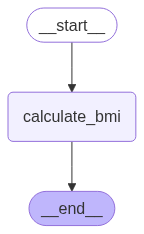

In [38]:
#define graph
graph=StateGraph(BMIState)

#add nodes to the graph
graph.add_node('calculate_bmi',calculate_bmi)

#add edges of the graph
graph.add_edge(START,'calculate_bmi')
graph.add_edge('calculate_bmi',END)

#workflow
workflow=graph.compile()
workflow

In [39]:
#execute the graph
workflow.invoke({'weight_kg':87,'height_cm':1.80})

{'weight_kg': 87, 'height_cm': 1.8, 'bmi': 26.85}

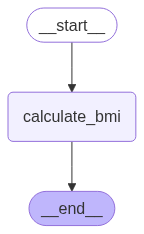

In [31]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [40]:
def calculate_bmi(state:BMIState)->BMIState:
    
    weight=state['weight_kg']
    height=state['height_cm']
    bmi=weight/(height**2)

    state['bmi']=round(bmi,2)
    return state

In [41]:

def label_bmi(state: BMIState) -> BMIState:

    bmi = state['bmi']

    if bmi < 18.5:
        state["category"] = "Underweight"
    elif 18.5 <= bmi < 25:
        state["category"] = "Normal"
    elif 25 <= bmi < 30:
        state["category"] = "Overweight"
    else:
        state["category"] = "Obese"

    return state

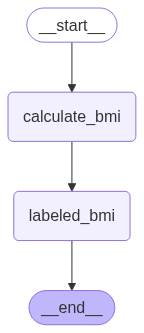

In [42]:
#define graph
graph=StateGraph(BMIState)

#add nodes to the graph
graph.add_node('calculate_bmi',calculate_bmi)
graph.add_node('labeled_bmi',label_bmi)

#add edges of the graph
graph.add_edge(START,'calculate_bmi')
graph.add_edge('calculate_bmi','labeled_bmi')
graph.add_edge('labeled_bmi',END)

#workflow
workflow=graph.compile()
workflow

In [43]:
workflow.invoke({'height_cm':1.8,'weight_kg':78})

{'weight_kg': 78, 'height_cm': 1.8, 'bmi': 24.07, 'category': 'Normal'}

**Simple LLM WorkFlow**

In [59]:
from langgraph.graph import StateGraph
from langchain_groq import ChatGroq
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import TypedDict
from dotenv import load_dotenv
import os
load_dotenv()
hf_token=os.getenv("HF_TOKEN")

In [55]:
llm = HuggingFaceEndpoint(
    repo_id="moonshotai/Kimi-K2-Instruct",  # Use the correct model repo_id
    task="text-generation",  # You can adjust this based on your model task
    model_kwargs={"headers": {"Authorization": f"Bearer {hf_token}"}}
)

model=ChatHuggingFace(llm=llm)

In [58]:
model.invoke("hi").content

'Hi there! How can I help you today?'

In [65]:
api=os.getenv('test_groq')
groq = ChatGroq(
    groq_api_key=api,  # Replace with your actual key
    model_name="meta-llama/llama-4-scout-17b-16e-instruct"
)

In [68]:
groq.invoke("hi").content

'Hi! How are you today? Is there something I can help you with or would you like to chat?'

In [69]:
class LLMState(TypedDict):
    
    question:str
    answer:str

In [ ]:
def llm_qa(state:LLMState)->LLMState:
    
    #extract the question from text
    question=state['question']
    #form a prompt
    prompt=f'answer the following {question}'
    #ask that question
    answer=groq.invoke(prompt).content
    #update the answer
    state['answer']=answer
    return state
    

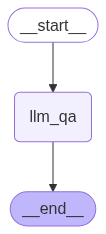

In [76]:
#create graph
graph=StateGraph(LLMState)

graph.add_node('llm_qa',llm_qa)

graph.add_edge(START,'llm_qa')
graph.add_edge('llm_qa',END)

workflow=graph.compile()
workflow

In [77]:
#execute

intial_state={'question':'how far is moon from the earth ?'}
final_state=workflow.invoke(intial_state)
print(final_state['answer'])

The average distance from the Earth to the Moon is approximately **384,400 kilometers (238,900 miles)**.

This distance is also known as the "lunar distance" or "lunar mean distance." It's worth noting that the Moon's orbit is not a perfect circle, so its distance from Earth varies slightly over the course of a month. At its closest point, known as perigee, the Moon is about 356,400 kilometers (221,500 miles) away, and at its farthest point, known as apogee, it's about 405,500 kilometers (252,000 miles) away.


**Prompt Chaining**

In [78]:
groq

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001D12C9BA0C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001D12C6052E0>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [79]:
class BlogState(TypedDict):
    title:str
    outline:str
    content:str
    

In [85]:
def create_outline(state:BlogState)->BlogState:
    
    #fetch title
    title=state['title']
    
    #call llm gen outline
    prompt=f'generate outline on blog topic --> {title}'
    outline=groq.invoke(prompt)
    
    #update state
    state['outline']=outline
    return state

In [86]:
def create_blog(state:BlogState)->BlogState:
    
    #fetch title
    title=state['title']
    outline=state['outline']
    
    #call llm gen outline
    prompt=f'write a detailed blog on the title --> {title}  using following outline \n {outline}'
    content=groq.invoke(prompt)
    
    #update state
    state['content']=content
    return state

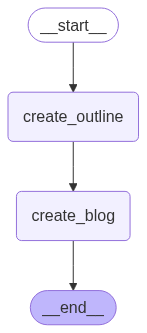

In [84]:
from token import STAR


graph=StateGraph(BlogState)

#nodes
graph.add_node('create_outline',create_outline)
graph.add_node('create_blog',create_blog)

graph.add_edge(START,'create_outline')
graph.add_edge('create_outline','create_blog')
graph.add_edge('create_blog',END)

workflow=graph.compile()
workflow

In [90]:
from sympy import pretty_print


intial_state={'title':'Rise of AI in India'}
final_state=workflow.invoke(intial_state)
pretty_print(final_state)

{content: content='The Rise of AI in India – From Policy to Practice  \nA 360- ↪

↪ degree tour of how the world’s most populous democracy is turning algorithms ↪

↪  into public goods, profits, and power.\n\n1. Hook & Context  \n“India’s AI  ↪

↪ market will touch $7.8 billion by 2025—more than the GDP of 50 countries.”   ↪

↪ \nThat single NASSCOM projection is why boardrooms from Boston to Beijing ar ↪

↪ e penciling in “India” on their AI roadmaps. While the US and China hog head ↪

↪ lines, India is quietly assembling the largest triad of data, developers, an ↪

↪ d democratic intent on the planet. Miss this story and you miss the next dec ↪

↪ ade of global tech.\n\n2. A Brief History of AI in India  \n1980s–2000s: The ↪

↪  Lab Years  \n• IIT-Kanpur’s first AI course (1984) and the iconic “Fifth Ge ↪

↪ neration Computer Systems” project at CDAC.  \n• Infosys & Wipro sell rule-b ↪

↪ ased automation to Y2K clients—India’s first AI exports are really expert-sy ↪

↪ stems maintena

In [89]:
final_state['content'].pretty_print()

================================== Ai Message ==================================

The Rise of AI in India – From Policy to Practice  
A 360-degree tour of how the world’s most populous country is turning algorithms into impact

--------------------------------------------------------------------
1. Hook & Context  
--------------------------------------------------------------------
“₹17 billion by 2030” is no longer a headline pulled from a consulting deck—it is NASSCOM’s latest projection for India’s artificial-intelligence market. To put that in perspective, the figure is larger than the GDP of 50+ countries today.  

But what exactly is “AI in India” in 2024? It is not a single monolithic stack. It is:  
• 1,300+ start-ups from Bengaluru to Bhubaneswar hacking on LLMs and computer-vision APIs.  
• Government departments using predictive models to route PDS trucks and detect TB in chest X-rays.  
• Global captives—Google Research India, Microsoft IDC, AWS Hyderabad—shipping features

In [2]:
pip install langchain_tavily



  Attempting uninstall: aiosignal

    Found existing installation: aiosignal 1.2.0

    Uninstalling aiosignal-1.2.0:

      Successfully uninstalled aiosignal-1.2.0

  Attempting uninstall: aiohappyeyeballs

    Found existing installation: aiohappyeyeballs 2.4.0

   ------------- -------------------------- 2/6 [aiohappyeyeballs]
    Uninstalling aiohappyeyeballs-2.4.0:
   ------------- -------------------------- 2/6 [aiohappyeyeballs]
      Successfully uninstalled aiohappyeyeballs-2.4.0
   ------------- -------------------------- 2/6 [aiohappyeyeballs]
  Attempting uninstall: yarl
   ------------- -------------------------- 2/6 [aiohappyeyeballs]
    Found existing installation: yarl 1.11.0
   ------------- -------------------------- 2/6 [aiohappyeyeballs]
    Uninstalling yarl-1.11.0:
   ------------- -------------------------- 2/6 [aiohappyeyeballs]
   -------------------- ------------------- 3/6 [yarl]
      Successfully uninstalled yarl-1.11.0
   -------------------- --------

In [3]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.8/v/value_error